# Data Pre-Processing

In [531]:
import sys
print(sys.version)
import xlrd
from collections import namedtuple
import pandas as pd
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
from statistics import median
import seaborn as sns
%matplotlib inline
from matplotlib.gridspec import GridSpec
from math import fabs
from sklearn.preprocessing import StandardScaler, Normalizer, PowerTransformer
from sklearn.cluster import MeanShift, AgglomerativeClustering, DBSCAN
from scipy.cluster.hierarchy import dendrogram
import matplotlib.ticker as ticker

3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0]


#### Read .xlsx workbooks

In [2]:
homes = xlrd.open_workbook('Athlete Home Base.xlsx')
views = xlrd.open_workbook('Video Views by Athlete.xlsx')

#### Map Athlete to Homebase

In [3]:
def map_athlete_to_homebase(xlrd_wb):
    '''Iterates over each row, skipping the first row
       Returns dict of athlete: homebase'''
    athlete_homebase_map = {}

    homes_iterrows = homes.sheet_by_index(0).get_rows()
    next(homes_iterrows)  # Skip header
    for row in homes_iterrows:
        athlete_homebase_map[row[0].value] = row[1].value  # row[0].value is athlete, row[1].value is homebase

    return athlete_homebase_map


athlete_homebase_map = map_athlete_to_homebase(homes)
athlete_homebase_map

{'A-a': 'Pink',
 'A-d': 'Brick',
 'A-e': 'Grey',
 'A-g': 'Purple',
 'A-i': 'Mahogany',
 'A-k': 'Blue',
 'A-l': 'White',
 'A-m': 'Blue',
 'A-n': 'Grey',
 'A-o': 'Blue',
 'A-r': 'Yellow',
 'A-s': 'Beige',
 'A-t': 'Garnet',
 'A-u': 'Magenta',
 'A-v': 'Orchid',
 'A-y': 'Yellow',
 'B-a': 'White',
 'B-e': 'Cerulean',
 'B-l': 'Bronze',
 'B-n': 'Gold',
 'B-o': 'Cherry',
 'B-r': 'Purple',
 'B-s': 'Beige',
 'B-v': 'Orchid',
 'B-y': 'Silver',
 'C-a': 'Rose',
 'C-e': 'Grey',
 'C-g': 'Green',
 'C-i': 'Green',
 'C-n': 'Pearl',
 'C-r': 'Rust',
 'C-s': 'Garnet',
 'C-t': 'Gold',
 'C-w': 'Garnet',
 'D-a': 'White',
 'D-d': 'White',
 'D-e': 'Silver',
 'D-i': 'Silver',
 'D-k': 'Orange',
 'D-m': 'Orange',
 'D-n': 'Gold',
 'D-o': 'Gold',
 'D-v': 'Orchid',
 'E-a': 'Blue',
 'E-g': 'White',
 'E-i': 'Cherry',
 'E-l': 'Rust',
 'E-n': 'Blue',
 'E-o': 'Blue',
 'E-r': 'Blue',
 'E-y': 'White',
 'E-z': 'Gold',
 'F-a': 'Lavender',
 'F-d': 'Teal',
 'F-g': 'Green',
 'F-i': 'Cherry',
 'F-n': 'Crimson',
 'F-r': 'Blue',
 'G

In [4]:
# Create Post namedtuple for formatting before instantiating DataFrame
post_cols = ['Athlete',
             'Black_City_Views',
             'Blue_City_Views',
             'Gold_City_Views',
             'Green_City_Views',
             'Grey_City_Views',
             'Orange_City_Views',
             'Pink_City_Views',
             'Purple_City_Views',
             'Red_City_Views',
             'Silver_City_Views',
             'White_City_Views',
             'Yellow_City_Views',
             'Homebase',
             'Post_Date']

Post = namedtuple('Post', post_cols)

#### Create list of Posts

In [5]:
def import_posts(xlrd_wb):
    '''Iterates over each row, skipping the first row, of each sheet
       Fills missing values with zeros
       Returns list of Posts'''
    posts = []
    
    sheet_names = views.sheet_names()
    for sheet_name in sheet_names:
        views_iterrows = views.sheet_by_name(sheet_name).get_rows()
        next(views_iterrows)  # Skip header
        for row in views_iterrows:
            athlete = row[0].value
            
            # Index 0 is athlete, Index -1 is Post Count
            views_vals = [int(cell.value) if (type(cell.value) != str) else 0 for cell in row[1:-1]]  
            try:
                home = athlete_homebase_map[athlete]
            except KeyError:  # In many cases, the athlete can't be found in athlete_homebase_map
                home = ''
                
            # Given that the prompt was "...when deciding which athletes to promote", posts with no athletes are not considered    
            if athlete not in ['All Posts', 'Posts with Athletes', 'Posts with No Athletes']:
                post = Post(athlete, *views_vals, home, sheet_name)
                posts.append(post)
            
    return posts
            
            
posts = import_posts(views)
pprint(posts[::len(posts)//3]) # Preview 3 Posts

[Post(Athlete='J-l', Black_City_Views=106111, Blue_City_Views=146601, Gold_City_Views=0, Green_City_Views=0, Grey_City_Views=0, Orange_City_Views=0, Pink_City_Views=0, Purple_City_Views=92633, Red_City_Views=15770, Silver_City_Views=23935, White_City_Views=172017, Yellow_City_Views=138004, Homebase='', Post_Date='Jan 2019'),
 Post(Athlete='H-i', Black_City_Views=26175, Blue_City_Views=149421, Gold_City_Views=0, Green_City_Views=0, Grey_City_Views=3433, Orange_City_Views=3538, Pink_City_Views=3084, Purple_City_Views=77074, Red_City_Views=23222, Silver_City_Views=46321, White_City_Views=57084, Yellow_City_Views=0, Homebase='Pink', Post_Date='Feb 2019'),
 Post(Athlete='A-g', Black_City_Views=10649, Blue_City_Views=71104, Gold_City_Views=14744, Green_City_Views=2856, Grey_City_Views=2248, Orange_City_Views=0, Pink_City_Views=1746, Purple_City_Views=113537, Red_City_Views=14481, Silver_City_Views=18096, White_City_Views=40622, Yellow_City_Views=16299, Homebase='Purple', Post_Date='Mar 2019'

#### Load Posts into Formatted DataFrame

In [52]:
posts_df = pd.DataFrame(posts).set_index(['Post_Date', 'Athlete'])  # Create multi-index
posts_df = posts_df.replace(0, np.nan)  # Replace 0s with NaNs to not include invalid data in statistical analysis
posts_df

Black_City_Views  Blue_City_Views  Gold_City_Views  \
Post_Date Athlete                                                       
Jan 2019  J-l              106111.0         146601.0              NaN   
          A-s               37222.0         185808.0           5832.0   
          R-n               37222.0         185808.0           5832.0   
          D-n                5587.0          57614.0          10335.0   
          A-i               36969.0         270983.0          28459.0   
...                             ...              ...              ...   
May 2019  S-d                3021.0          80226.0           2809.0   
          Y-a                3021.0          80226.0           2809.0   
          J-n                1431.0          38582.0           1189.0   
          R-n                1431.0          38582.0           1189.0   
          Z-g                8827.0           4070.0          32076.0   

                   Green_City_Views  Grey_City_Views  Orange_City_Views  \
Post_Date Athlete                                                         
Jan 2019  J-l                   NaN              NaN                NaN   
          A-s                   NaN              NaN                NaN   
          R-n                   NaN              NaN                NaN   
          D-n                   NaN           2950.0                NaN   
          A-i                   NaN           5672.0                NaN   
...                             ...              ...                ...   
May 2019  S-d                1232.0            309.0              190.0   
          Y-a                1232.0            309.0              190.0   
          J-n                  93.0            519.0              166.0   
          R-n                  93.0            519.0              166.0   
          Z-g                   NaN           1054.0              511.0   

                   Pink_City_Views  Purple_City_Views  Red_City_Views  \
Post_Date Athlete                                                       
Jan 2019  J-l                  NaN            92633.0         15770.0   
          A-s                  NaN            75722.0         12115.0   
          R-n                  NaN            75722.0         12115.0   
          D-n                  NaN           233128.0         15634.0   
          A-i                  NaN           537637.0         49316.0   
...                            ...                ...             ...   
May 2019  S-d                341.0            36634.0          2459.0   
          Y-a                341.0            36634.0          2459.0   
          J-n                197.0             6747.0          1494.0   
          R-n                197.0             6747.0          1494.0   
          Z-g                545.0            10980.0          7770.0   

                   Silver_City_Views  White_City_Views  Yellow_City_Views  \
Post_Date Athlete                                                           
Jan 2019  J-l                23935.0          172017.0           138004.0   
          A-s                16313.0           35808.0           226733.0   
          R-n                16313.0           35808.0           226733.0   
          D-n                36425.0           50572.0            22842.0   
          A-i               104028.0           82388.0           119360.0   
...                              ...               ...                ...   
May 2019  S-d                 2379.0           18124.0             9214.0   
          Y-a                 2379.0           18124.0             9214.0   
          J-n                 1592.0            8074.0             2520.0   
          R-n                 1592.0            8074.0             2520.0   
          Z-g                 9695.0            6521.0             4300.0   

                   Homebase  
Post_Date Athlete            
Jan 2019  J-l                
          A-s         Beige  
          R-n        

# Data Visualization

#### Identifying Under-Represented Athletes

In [8]:
views_dict = posts_df.groupby('Athlete').size().to_dict()
for key in athlete_homebase_map.keys():
    if key not in views_dict:
        views_dict[key] = 0
views_dict = {k: v for k, v in sorted(views_dict.items(), key=lambda x: x[1])}
views_dict

{'A-k': 0,
 'A-m': 0,
 'A-y': 0,
 'B-v': 0,
 'C-n': 0,
 'D-k': 0,
 'F-d': 0,
 'F-g': 0,
 'F-i': 0,
 'G-r': 0,
 'H-h': 0,
 'H-k': 0,
 'H-n': 0,
 'J-m': 0,
 'K-i': 0,
 'M-f': 0,
 'M-l': 0,
 'M-y': 0,
 'N-e': 0,
 'N-g': 0,
 'O-c': 0,
 'O-h': 0,
 'O-t': 0,
 'P-a': 0,
 'P-m': 0,
 'R-d': 0,
 'R-h': 0,
 'S-e': 0,
 'S-h': 0,
 'S-s': 0,
 'T-m': 0,
 'T-y': 0,
 'V-g': 0,
 'V-k': 0,
 'W-r': 0,
 'X-o': 0,
 'Y-g': 0,
 'Z-o': 0,
 'A-l': 1,
 'A-t': 1,
 'B-o': 1,
 'C-a': 1,
 'C-k': 1,
 'D-u': 1,
 'E-.': 1,
 'H-e': 1,
 'H-u': 1,
 'I-o': 1,
 'J-i': 1,
 'J-l': 1,
 'M-I': 1,
 'M-a': 1,
 'M-d': 1,
 'M-g': 1,
 'P-f': 1,
 'P-g': 1,
 'S-9': 1,
 'S-k': 1,
 'T-a': 1,
 'V-a': 1,
 'V-t': 1,
 'C-r': 2,
 'C-w': 2,
 'D-i': 2,
 'D-v': 2,
 'E-o': 2,
 'F-n': 2,
 'F-r': 2,
 'H-a': 2,
 'I-d': 2,
 'I-z': 2,
 'J-t': 2,
 'J-z': 2,
 'K-e': 2,
 'N-i': 2,
 'N-v': 2,
 'Q-s': 2,
 'R-v': 2,
 'R-z': 2,
 'S-m': 2,
 'Y-e': 2,
 'A-d': 3,
 'B-e': 3,
 'B-i': 3,
 'B-y': 3,
 'F-a': 3,
 'L-a': 3,
 'L-i': 3,
 'P-o': 3,
 'R-i': 3,
 'S-d': 3,

In [535]:
zeros = 0
for v in views_dict.values():
    if v == 0:
        zeros += 1
zeros

38

In [92]:
total_views = sum(views_dict.values())

cumul_views = 0
underrep_athletes = {}
iter_view = iter(views_dict.items())
while cumul_views < total_views*.2:  # To get 80-20 split
    
    next_view = next(iter_view)
    
    cumul_views += next_view[1]
    underrep_athletes[next_view[0]] = next_view[1]
    
overrep_athletes = {k: v for k, v in views_dict.items() if k not in underrep_athletes}

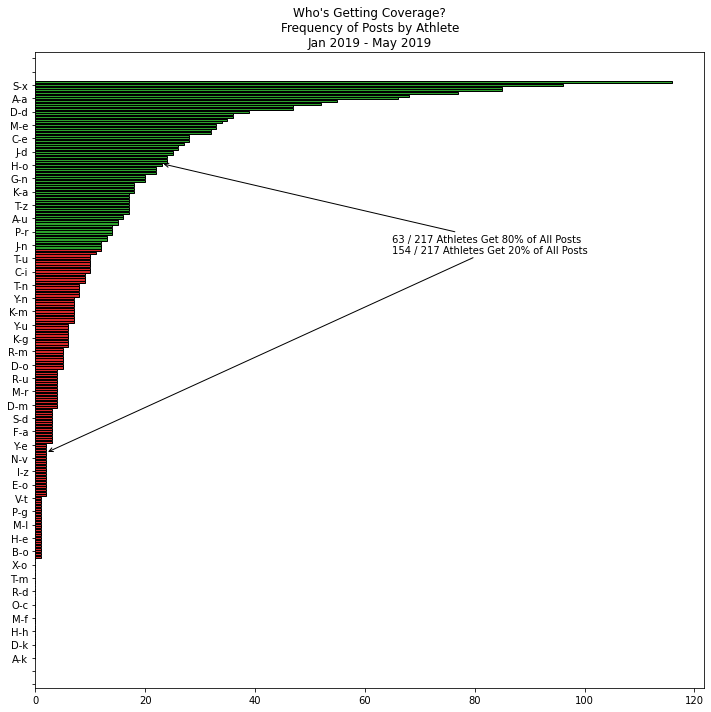

In [533]:
fig, ax = plt.subplots(figsize=(10, 10), tight_layout=True)
ax.barh(list(underrep_athletes.keys()), underrep_athletes.values(), color='tab:red', edgecolor='black')
ax.barh(list(overrep_athletes.keys()), overrep_athletes.values(), color='tab:green', edgecolor='black')
ax.set_title('Who\'s Getting Coverage?\nFrequency of Posts by Athlete\nJan 2019 - May 2019')
x_pos_over = median(overrep_athletes.values())             
x_pos_under = median(underrep_athletes.values())
y_pos_over = len(underrep_athletes) + len(overrep_athletes)/2
y_pos_under = len(underrep_athletes)/2
ax.annotate(f"{len(overrep_athletes)} / {len(views_dict)} Athletes Get 80% of All Posts", 
            xy=(x_pos_over, y_pos_over), xytext=(65.0, len(underrep_athletes)+2), arrowprops=dict(arrowstyle="->"))
ax.annotate(f"{len(underrep_athletes)} / {len(views_dict)} Athletes Get 20% of All Posts", 
            xy=(x_pos_under, y_pos_under), xytext=(65.0, len(underrep_athletes)-2), arrowprops=dict(arrowstyle="->"))

ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
fig.show()

#### Identifying Successful Athletes

In [116]:
popular = posts_df.groupby('Athlete').mean()
scaled_popular = (popular-popular.min())/(popular.max()-popular.min())
standardized_popular = (popular-popular.mean())/popular.std()

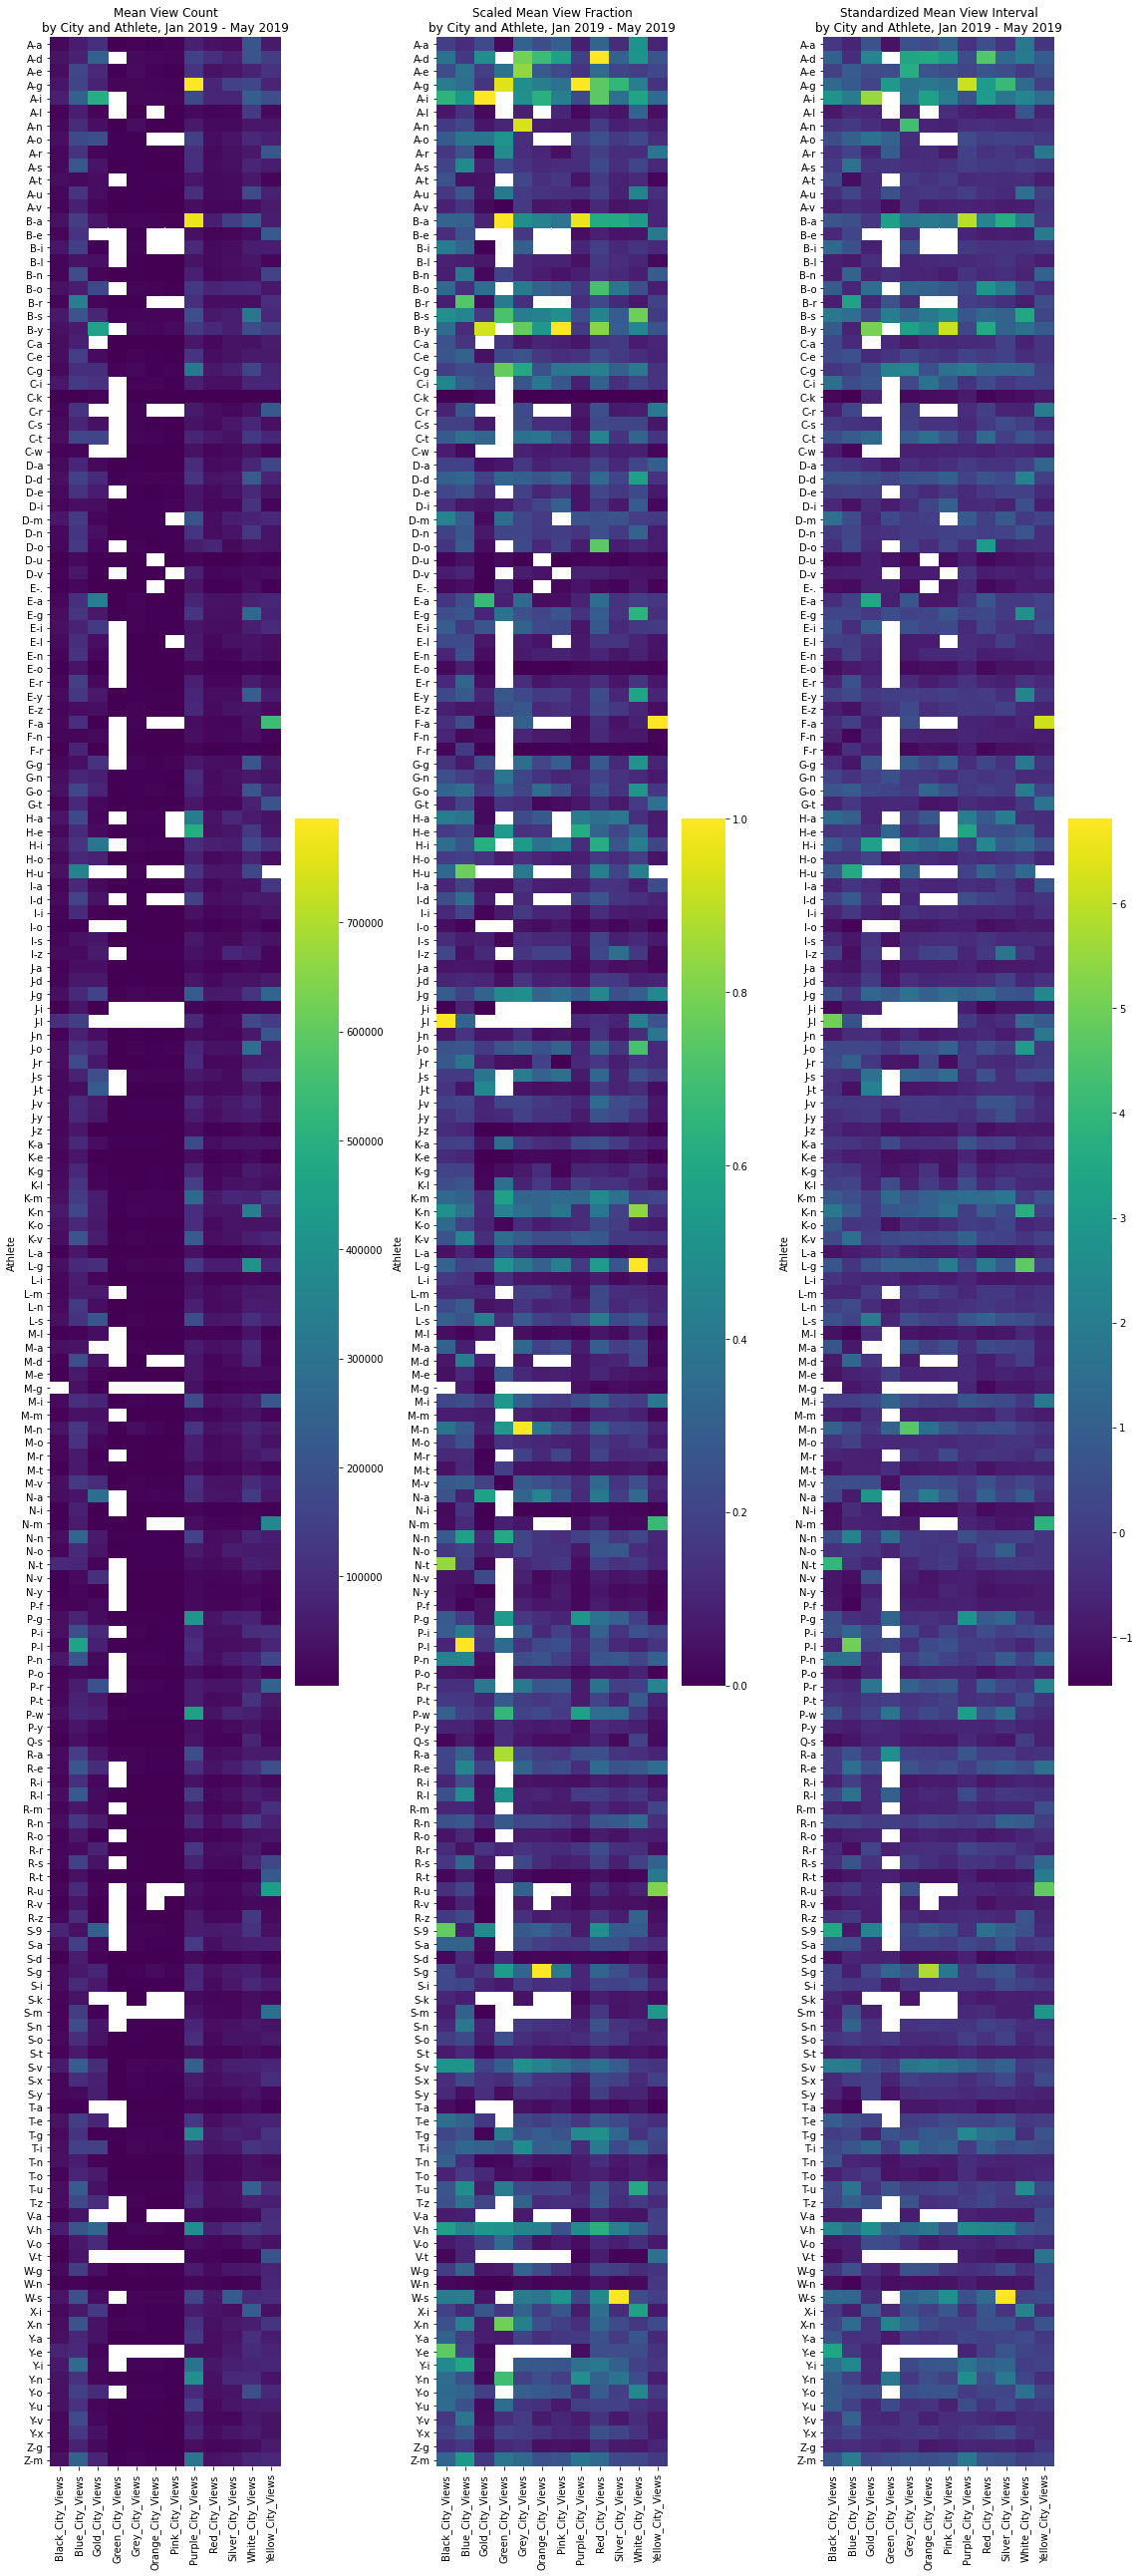

In [303]:
fig, ax = plt.subplots(ncols=3, figsize=(16, 36), tight_layout=True)
sns.heatmap(popular, cmap='viridis', ax=ax[0])
sns.heatmap(scaled_popular, cmap='viridis', ax=ax[1])
sns.heatmap(standardized_popular, cmap='viridis', ax=ax[2])
ax[0].set_title('Mean View Count\nby City and Athlete, Jan 2019 - May 2019')
ax[1].set_title('Scaled Mean View Fraction\nby City and Athlete, Jan 2019 - May 2019')
ax[2].set_title('Standardized Mean View Interval\nby City and Athlete, Jan 2019 - May 2019')
fig.show()

In [538]:
mean_standardized_popular = standardized_popular.mean(axis=1)
represented = posts_df.groupby('Athlete').size()

HEAD = 5
def filter_sort_plot(col):
    f_sorted = standardized_popular[col].sort_values(ascending=False).head(HEAD)
    return f_sorted.index, f_sorted.values

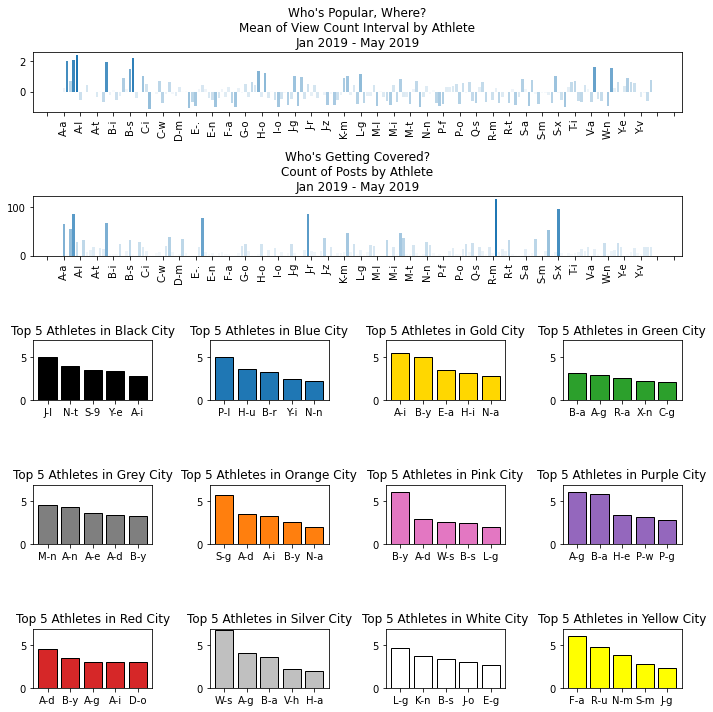

In [542]:
fig = plt.figure(figsize=(10, 10), tight_layout=True)
gs = GridSpec(5, 4, figure=fig)
ax0 = fig.add_subplot(gs[0, :])
ax0.bar(mean_standardized_popular.index, mean_standardized_popular.values)
ax0.xaxis.set_tick_params(rotation=90)
ax0.set_title('Who\'s Popular, Where?\nMean of View Count Interval by Athlete\nJan 2019 - May 2019')
ax0.xaxis.set_major_locator(ticker.MultipleLocator(5))

ax1 = fig.add_subplot(gs[1, :])
ax1.bar(represented.index, represented.values)
ax1.xaxis.set_tick_params(rotation=90)
ax1.set_title('Who\'s Getting Covered?\nCount of Posts by Athlete\nJan 2019 - May 2019')
ax1.xaxis.set_major_locator(ticker.MultipleLocator(5))

ax2 = fig.add_subplot(gs[2, 0])
ax3 = fig.add_subplot(gs[2, 1])
ax4 = fig.add_subplot(gs[2, 2])
ax5 = fig.add_subplot(gs[2, 3])
ax6 = fig.add_subplot(gs[3, 0])
ax7 = fig.add_subplot(gs[3, 1])
ax8 = fig.add_subplot(gs[3, 2])
ax9 = fig.add_subplot(gs[3, 3])
ax10 = fig.add_subplot(gs[4, 0])
ax11 = fig.add_subplot(gs[4, 1])
ax12 = fig.add_subplot(gs[4, 2])
ax13 = fig.add_subplot(gs[4, 3])

for ax in (ax0, ax1):
    height_max = max([bar.get_height() for bar in ax.get_children() if hasattr(bar, 'get_height')])
    for bar in ax.get_children():
        if hasattr(bar, 'get_height'):
            height = fabs(bar.get_height())
            bar.set_alpha(height / height_max)

for ax, color in zip([ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13], 
                     ['Black_City_Views',
                      'Blue_City_Views',
                      'Gold_City_Views',
                      'Green_City_Views',
                      'Grey_City_Views',
                      'Orange_City_Views',
                      'Pink_City_Views',
                      'Purple_City_Views',
                      'Red_City_Views',
                      'Silver_City_Views',
                      'White_City_Views', 
                      'Yellow_City_Views']):
    try:
        ax.bar(*filter_sort_plot(color), color='tab:' + color.split('_')[0].lower(), edgecolor='black')
        
    except ValueError:
        ax.bar(*filter_sort_plot(color), color=color.split('_')[0], edgecolor='black')
    ax.set_ylim(0, 7)
    ax.set_title((f"Top {HEAD} Athletes in " + color.replace('_', ' '))[:-6])
fig.show()

#### Quantifying Homebase Advantage

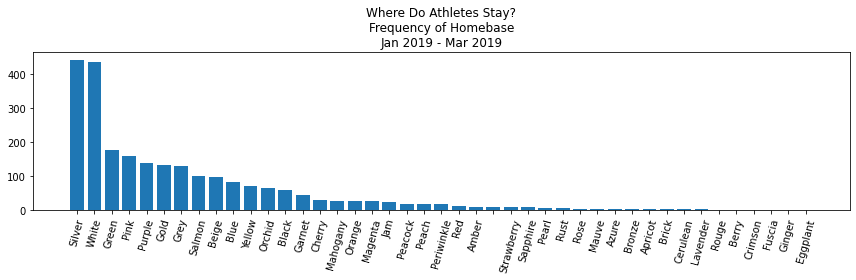

In [323]:
homebase_count = posts_df.groupby('Homebase').size().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(12, 4), tight_layout=True)
ax.bar(homebase_count.index, homebase_count.values)
ax.xaxis.set_tick_params(rotation=75)
ax.set_title('Where Do Athletes Stay?\nFrequency of Homebase\nJan 2019 - Mar 2019')
fig.show()

In [295]:
corr_df = posts_df.groupby('Homebase').mean().drop('')
standard_corr_df = (corr_df-corr_df.mean())/corr_df.std()

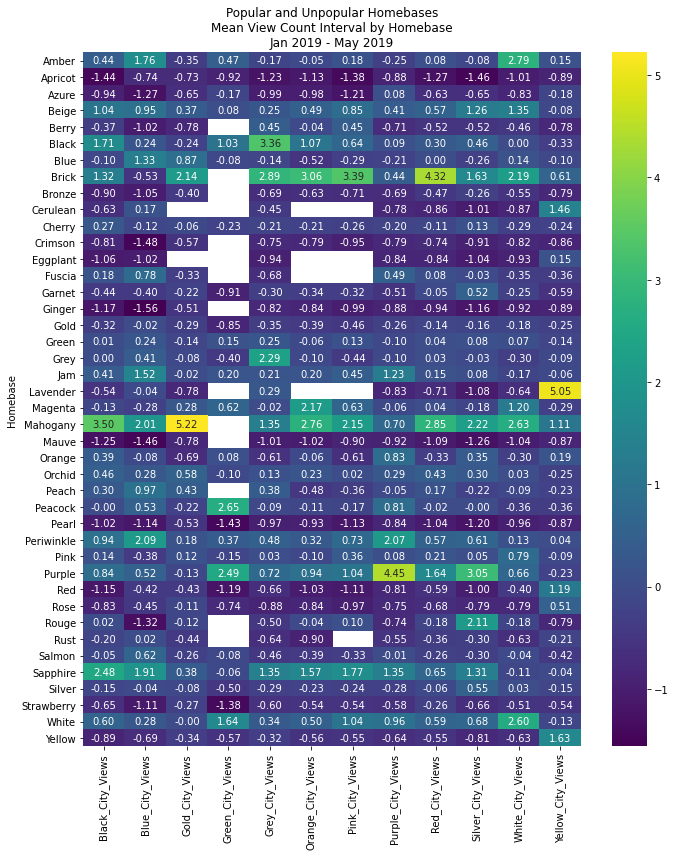

In [316]:
fig, ax = plt.subplots(figsize=(10, 12), tight_layout=True)
sns.heatmap(standard_corr_df, cmap='viridis', ax=ax, annot=True, fmt='.2f')
ax.set_title('Popular and Unpopular Homebases\nMean View Count Interval by Homebase\nJan 2019 - May 2019')
fig.show()

#### Correlation Between Cities

In [560]:
mean

Black_City_Views  Blue_City_Views  Gold_City_Views  Green_City_Views  \
Athlete                                                                         
A-a          19714.390625     59673.924242    111806.714286        341.000000   
A-d          39832.000000     74408.333333    240781.500000               NaN   
A-e          24962.309091    169072.763636     93042.125000       3822.000000   
A-g          44752.094118    163808.154762     76004.474359       9522.628571   
A-i          68811.500000    240843.285714    492958.521739               NaN   
...                   ...              ...              ...               ...   
Y-u          37179.166667    112359.333333     14843.333333       3586.000000   
Y-v          17566.500000    179336.000000     18410.500000       1405.000000   
Y-x          21336.647059    124755.411765     35978.692308       2104.000000   
Z-g          14578.882353     75961.647059     19950.222222       1210.500000   
Z-m          34829.176471    246389.588235     81209.538462       3950.000000   

         Grey_City_Views  Orange_City_Views  Pink_City_Views  \
Athlete                                                        
A-a          8892.754717        5653.622222      6825.540000   
A-d         21756.500000       16509.500000     12693.500000   
A-e         23004.075000        6774.500000      5096.555556   
A-g         13581.828947       10503.528571      8440.661290   
A-i         13930.533333       15385.555556      9561.888889   
...                  ...                ...              ...   
Y-u          4571.500000        3512.666667      1675.500000   
Y-v          5098.500000        1840.000000      2575.500000   
Y-x          5199.583333        3783.300000      2743.666667   
Z-g          4062.363636        1146.750000      1301.800000   
Z-m          9508.625000        6088.428571      5961.400000   

         Purple_City_Views  Red_City_Views  Silver_City_Views  \
Athlete                                                         
A-a           69704.742424    35726.636364       29790.757576   
A-d          149896.333333   110807.666667       73583.333333   
A-e          122690.400000    39341.254545       48526.036364   
A-g          795018.488095    83182.273810      152770.976190   
A-i          175069.464286    82602.678571       86989.607143   
...                    ...             ...                ...   
Y-u          150920.333333    22815.833333       45661.000000   
Y-v           60377.250000    17185.000000       16627.250000   
Y-x           86890.647059    27640.117647       47079.941176   
Z-g           30901.000000    14829.117647       17371.058824   
Z-m          308793.000000    38741.176471       50654.000000   

         White_City_Views  Yellow_City_Views  
Athlete                                       
A-a         206014.909091       55355.983607  
A-d         208698.666667      141688.000000  
A-e          76033.818182      117956.777778  
A-g         170446.317647       79167.590361  
A-i         235276.142857      187171.695652  
...                   ...                ...  
Y-u          63743.166667       65747.200000  
Y-v          51284.500000       39585.333333  
Y-x          61905.352941       38118.312500  
Z-g          27959.941176       58394.666667  
Z-m          85565.823529       90283.437500  

[179 rows x 12 columns]

In [572]:
mean = posts_df.groupby('Athlete').mean()
scaled = (mean - mean.min()) / (mean.max() - mean.min())
transf = scaled * 2 - 1
corr = transf.corr()

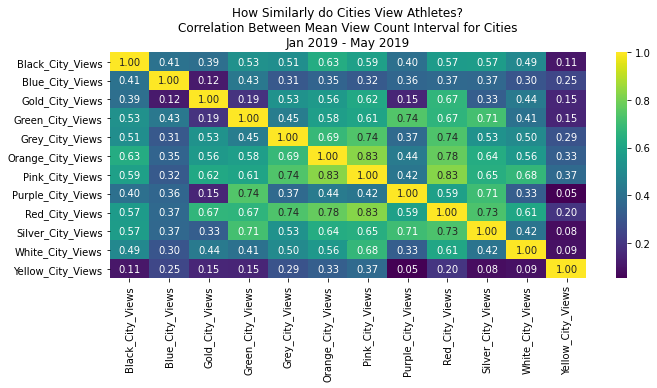

In [574]:
fig, ax = plt.subplots(figsize=(10, 5.5), tight_layout=True)
sns.heatmap(corr, cmap='viridis', ax=ax, annot=True, fmt='.2f')
ax.set_title('How Similarly do Cities View Athletes?\nCorrelation Between Mean View Count Interval for Cities\nJan 2019 - May 2019')
fig.show()

# Machine Learning

#### Clustering Homebases by City Affinity

In [448]:
filled_df = StandardScaler().fit_transform(posts_df.groupby('Homebase').mean().fillna(.0).drop(''))
for model in (MeanShift, AgglomerativeClustering, DBSCAN):
    clustering = model().fit(filled_df)
    print(model.__name__, clustering.labels_)

MeanShift [0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 4 0 1 0 0 0 0 0 0 3 0 3 0 0 0 0 0
 3 0 0 3 0]
AgglomerativeClustering [0 1 1 0 1 0 0 0 1 1 0 1 1 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1 0
 0 0 1 0 1]
DBSCAN [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


In [447]:
filled_df = normalize(posts_df.groupby('Homebase').mean().fillna(.0).drop(''))
for model in (MeanShift, AgglomerativeClustering, DBSCAN):
    clustering = model().fit(filled_df)
    print(model.__name__, clustering.labels_)

MeanShift [0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 2 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 2 0 0
 0 0 0 0 1]
AgglomerativeClustering [0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0
 0 0 0 0 1]
DBSCAN [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0]


In [446]:
filled_df = standard_corr_df.fillna(.0)
for model in (MeanShift, AgglomerativeClustering, DBSCAN):
    clustering = model().fit(filled_df)
    print(model.__name__, clustering.labels_)

MeanShift [0 0 0 0 0 2 0 3 0 0 0 0 0 0 0 0 0 0 0 0 5 0 1 0 0 0 0 0 0 2 0 4 0 0 0 0 0
 2 0 0 2 0]
AgglomerativeClustering [0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1
 0 1 1 0 1]
DBSCAN [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


#### Clustering Athletes by City Affinity

In [458]:
athletes_df = posts_df.groupby('Athlete').mean().fillna(posts_df.mean())
scaled = StandardScaler().fit_transform(athletes_df)
normed = Normalizer().fit_transform(athletes_df)
power = PowerTransformer().fit_transform(athletes_df)

In [465]:
for model in (MeanShift, AgglomerativeClustering, DBSCAN):
    for data in (scaled, normed, power):
        clustering = model().fit(filled_df)
        print(model.__name__, clustering.labels_)

MeanShift [0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 4 0 1 0 0 0 0 0 0 3 0 3 0 0 0 0 0
 3 0 0 3 0]
MeanShift [0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 4 0 1 0 0 0 0 0 0 3 0 3 0 0 0 0 0
 3 0 0 3 0]
MeanShift [0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 4 0 1 0 0 0 0 0 0 3 0 3 0 0 0 0 0
 3 0 0 3 0]
AgglomerativeClustering [0 1 1 0 1 0 0 0 1 1 0 1 1 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1 0
 0 0 1 0 1]
AgglomerativeClustering [0 1 1 0 1 0 0 0 1 1 0 1 1 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1 0
 0 0 1 0 1]
AgglomerativeClustering [0 1 1 0 1 0 0 0 1 1 0 1 1 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1 0
 0 0 1 0 1]
DBSCAN [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
DBSCAN [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
DBSCAN [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1

In [504]:
def plot_dendrogram(model, **kwargs):

    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

ward [13  2  6  9  2  3  5  6  0  4  7 13 19  9  0 10  1 11 14  4  2  2 11  5
  2 14 12  0  7 14  1 11 13  7 18 10  5  4  8  3  8  5 13 14  7  3 12  3
 13 18  0  1 12 13  4 13 11 10 10  2 11  6 11  4 19  1 18  7 19 18  2 16
 15 11 13 11 14  1  5  5  8  4  8 11  4  2  2 11  6 19  2 19  7 11  5  1
  7  3 19 16  6  1  6 11  3 19  5 14 12  0  4  5 15  1  1  1 10  6  4 10
  1 14 13 10 19 19  6  6  3  4  3  5  3 18  0 17  0 16  3 14 10  8 14  5
  3  0  4  4 19  6  5 18  1  6 10 14 11 19 13  6  3  2  1  0  5 17  9 13
  6  5 15 10 10 13  4 11  5 19  6]
complete [ 8  6 14 12  6  3  7  1  1  0  0  8  4 12  2  1  5  4 13  1 14  6  0  0
 14 14  9  2  0 14  5  0  8  0  0  1  8  0 16  3 16  7  8  8  0  5  9  5
  8  0  2 19  9  8  0  8  4 15 15 14  0 14  4  0  4 19  0  0 11  4 14 18
 10  4  8  4  8  5  0  0 11  0 11  4  0 14 14  0 14 11 14 11  0  4  8 19
  0  3  5 18  1  5 14  4  3 11  8 13  9  2  1  0 10  5 19 19 15  1  1  1
 19  8  8 15  5 11  1  1  5  1  5  8  5  0  1 17  2 18  3 13  1 11 13  0
  

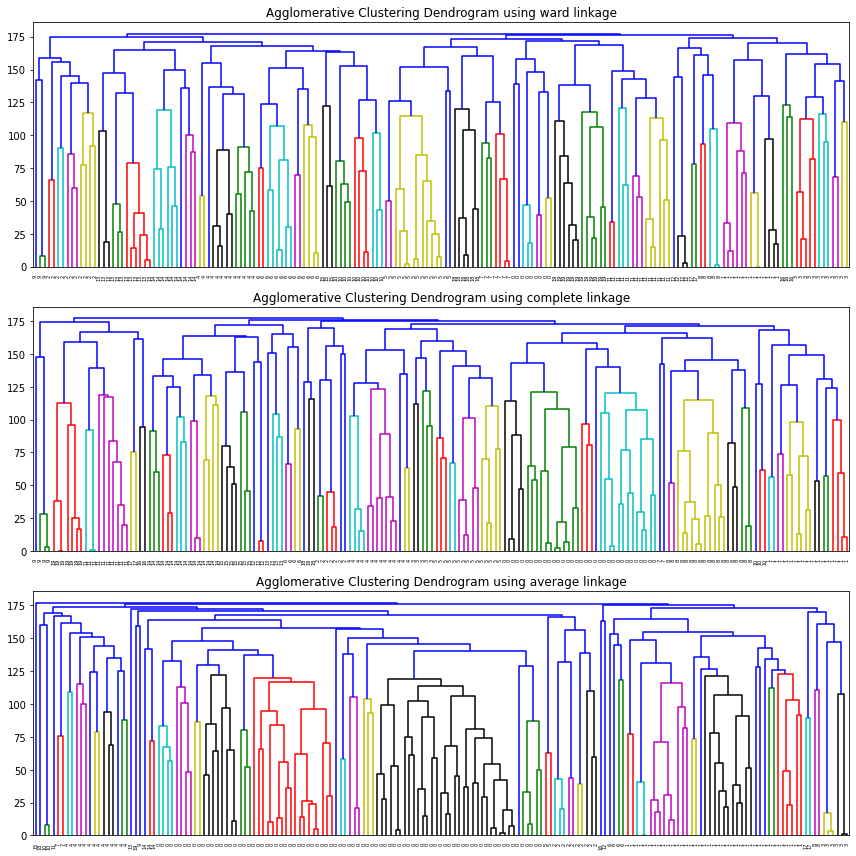

In [545]:
fig, ax = plt.subplots(nrows=3, figsize=(12, 12), tight_layout=True)

for ix, linkage in enumerate(['ward', 'complete', 'average']):

    clustering = AgglomerativeClustering(linkage=linkage, n_clusters=20).fit(power)
    print(f'{linkage}', clustering.labels_)
    plot_dendrogram(clustering, labels=clustering.labels_, ax=ax[ix])
    ax[ix].set_title(f'Agglomerative Clustering Dendrogram using {linkage} linkage')

fig.show()